In [118]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

permittivity_real = np.random.uniform(0, 10, 1000)
permittivity_imaginary = np.random.uniform(0, 0.1, 1000)
orientation = np.random.randint(1, 20, 1000) 
data = {
    'Frequency': np.linspace(1.0, 4.0, 1000),
    'Orientation':orientation,
    'S11 Real': np.random.uniform(-0.01, 0.02, 1000),
    'S12 Imaginary': np.random.uniform(0, 0.06, 1000),
    'S21 Real': np.random.uniform(-0.01, 0.02, 1000),
    'S22 Imaginary': np.random.uniform(0, 0.06, 1000),
    'Permittivity Real': permittivity_real,
    'Permittivity Imaginary': permittivity_imaginary
}
df = pd.DataFrame(data)
print(f"Output: {permittivity_real}")
print(f"Output: {permittivity_imaginary}")
print(f"Dataframe: ")
print(df)

Output: [2.85359586e+00 4.19392583e+00 9.42090158e+00 2.21213720e+00
 3.35048420e+00 4.76108016e+00 2.09348020e+00 9.56320678e+00
 8.21770243e+00 6.28094373e+00 8.93267629e+00 8.40296637e+00
 4.78886124e-01 6.87025662e+00 3.52955524e+00 8.15690612e+00
 9.66576847e+00 9.67602420e+00 1.72990075e+00 2.98375423e+00
 9.89638350e-01 3.99799928e-01 2.71138285e+00 1.48120369e+00
 1.46998518e+00 2.11258620e+00 2.53927771e-01 9.28325671e+00
 5.80283067e+00 1.06139926e+00 3.01611150e+00 7.20357337e+00
 2.73570724e+00 1.97405713e+00 4.05921400e+00 6.61562527e+00
 9.06681043e+00 3.23147180e+00 2.43284279e+00 6.59129930e+00
 3.58382154e+00 2.11695610e+00 1.15631971e+00 4.02707509e-01
 3.01502643e+00 3.44638114e-01 3.76374282e+00 2.84127892e+00
 8.65756804e+00 7.31005228e+00 2.07989328e-03 7.96616781e-01
 8.36119220e+00 7.24208339e+00 8.09060853e+00 5.59088906e+00
 3.56629655e+00 6.45200570e+00 3.74694867e+00 2.57614730e+00
 8.77808671e+00 8.50326296e+00 4.08202708e+00 1.94423670e+00
 7.12882108e+00 

In [119]:
df

,Frequency,Orientation,S11 Real,S12 Imaginary,S21 Real,S22 Imaginary,Permittivity Real,Permittivity Imaginary
0,1.000000,10,0.019973,0.029971,-0.009993,0.040941,2.853596,0.052436
1,1.003003,14,-0.004856,0.051028,0.001558,0.011024,4.193926,0.022718
2,1.006006,19,-0.001866,0.059045,-0.002621,0.000279,9.420902,0.075331
3,1.009009,9,0.019807,0.052066,0.000183,0.046106,2.212137,0.053770
4,1.012012,18,0.007921,0.037372,0.002822,0.049299,3.350484,0.087161
...,...,...,...,...,...,...,...,...
995,3.987988,10,0.010190,0.004158,0.008879,0.041226,5.535157,0.031776
996,3.990991,16,0.004847,0.059165,0.015223,0.047779,7.253458,0.030367
997,3.993994,8,0.019722,0.052489,0.010894,0.043264,7.575661,0.098028
998,3.996997,10,0.017695,0.025825,-0.003302,0.016677,9.795549,0.085662


In [120]:
df.columns = ['frequency','orientation','s11_real','s11_imaginary','s21_real','s22_imaginary','permittivity_real','permittivity_imaginary']

In [121]:
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit(df[['s11_real','s11_imaginary','s21_real','s22_imaginary','permittivity_real','permittivity_imaginary']])
df[['s11_real','s11_imaginary','s21_real','s22_imaginary','permittivity_real','permittivity_imaginary']] =  X_norm.transform(df[['s11_real','s11_imaginary','s21_real','s22_imaginary','permittivity_real','permittivity_imaginary']])

In [122]:
df['orientation'] = df['orientation'].astype('category')
df = pd.get_dummies(df, columns=['orientation'])

In [123]:
c = []
for i in df.columns:
    if i != permittivity_real or i !=permittivity_imaginary:
        c.append(i)

/var/folders/lk/g6q_4n912156v7109ds7l5mm0000gn/T/ipykernel_33531/1338281437.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if i != permittivity_real or i !=permittivity_imaginary:


In [124]:
df_original = df.copy()

In [125]:
X = df[c].values
y = df[['permittivity_real','permittivity_imaginary']].values

In [126]:
indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]
split_point = int(0.8 * len(X))
X_train = X[:split_point]
y_train = y[:split_point]
X_val = X[split_point:]
y_val = y[split_point:]

In [127]:
X_train.shape

(800, 26)

In [130]:
y_train.shape

(800, 2)

In [131]:
X_val.shape

(200, 26)

In [71]:
y_val.shape

(200, 2)

In [132]:
def mae_loss(y_true, y_pred):
    y_true_real, y_true_imag = tf.split(y_true, 2, axis=-1)
    y_pred_real, y_pred_imag = tf.split(y_pred, 2, axis=-1)
    loss_real = tf.losses.mean_absolute_error(y_true_real, y_pred_real)
    loss_imag = tf.losses.mean_absolute_error(y_true_imag, y_pred_imag)
    return loss_real + loss_imag
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(y.shape[1], activation='linear')
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              loss=[mae_loss],
              metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])

In [133]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               3456      
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 2)                 34        
                                                                 
Total params: 14354 (56.07 KB)
Trainable params: 14354 (56.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [134]:
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_val = X_val.astype(float)
y_val = y_val.astype(float)

Epoch 1/500
800/800 [==============================] - 1s 585us/step - loss: 0.5096 - mean_absolute_error: 0.2548 - mean_squared_error: 0.1000 - val_loss: 0.3930 - val_mean_absolute_error: 0.1965 - val_mean_squared_error: 0.0525
Epoch 2/500
800/800 [==============================] - 0s 548us/step - loss: 0.3098 - mean_absolute_error: 0.1549 - mean_squared_error: 0.0351 - val_loss: 0.2611 - val_mean_absolute_error: 0.1305 - val_mean_squared_error: 0.0244
Epoch 3/500
800/800 [==============================] - 0s 483us/step - loss: 0.1634 - mean_absolute_error: 0.0817 - mean_squared_error: 0.0112 - val_loss: 0.0888 - val_mean_absolute_error: 0.0444 - val_mean_squared_error: 0.0032
Epoch 4/500
800/800 [==============================] - 0s 476us/step - loss: 0.0701 - mean_absolute_error: 0.0351 - mean_squared_error: 0.0022 - val_loss: 0.0601 - val_mean_absolute_error: 0.0300 - val_mean_squared_error: 0.0014
Epoch 5/500
800/800 [==============================] - 0s 481us/step - loss: 0.0542 

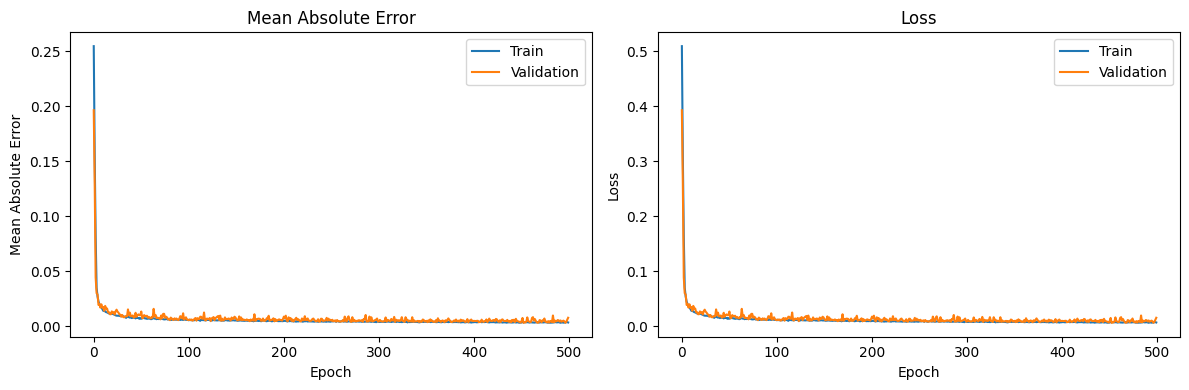

In [135]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(['Train', 'Validation'])
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()


In [136]:
# Find the column name with the maximum value for each row in the "df_encoded" DataFrame
collapse_orientation = df_original[['orientation_1', 'orientation_2', 'orientation_3', 'orientation_4',
                                   'orientation_5', 'orientation_6', 'orientation_7', 'orientation_8',
                                   'orientation_9', 'orientation_10', 'orientation_11', 'orientation_12',
                                   'orientation_13', 'orientation_14', 'orientation_15', 'orientation_16',
                                   'orientation_17', 'orientation_18', 'orientation_19']].idxmax(axis=1)

# Extract the integer part from the "collapse_orientation" labels and convert to int
collapse_orientation_int = collapse_orientation.str.extract(r'(\d+)').astype(int)

# Rename the column to 'orientation'
collapse_orientation_int.columns = ['orientation']


7/7 [==============================] - 0s 575us/step


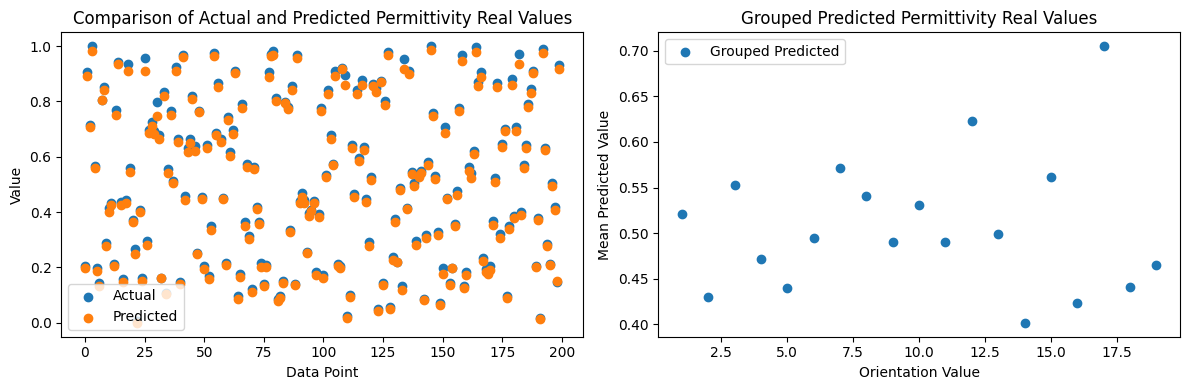

In [137]:
y_pred = model.predict(X_val)
# Create a DataFrame with "orientation_value" and "y_pred" columns
df_predicted = pd.DataFrame({'orientation_value': collapse_orientation_int['orientation'][split_point:], 'y_pred': y_pred[:, 0]})

# Group the predicted values by "orientation_value" and calculate the mean
y_pred_grouped = df_predicted.groupby('orientation_value')['y_pred'].mean().reset_index()

# Plot the comparison of actual and predicted permittivity real values for all data points
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_val)), y_val[:, 0], label='Actual')
plt.scatter(range(len(y_pred)), y_pred[:, 0], label='Predicted')
plt.title('Comparison of Actual and Predicted Permittivity Real Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

# Plot the grouped predicted permittivity real values for each orientation category
plt.subplot(1, 2, 2)
plt.scatter(y_pred_grouped['orientation_value'], y_pred_grouped['y_pred'], label='Grouped Predicted')
plt.title('Grouped Predicted Permittivity Real Values')
plt.xlabel('Orientation Value')
plt.ylabel('Mean Predicted Value')
plt.legend()

plt.tight_layout()
plt.show()


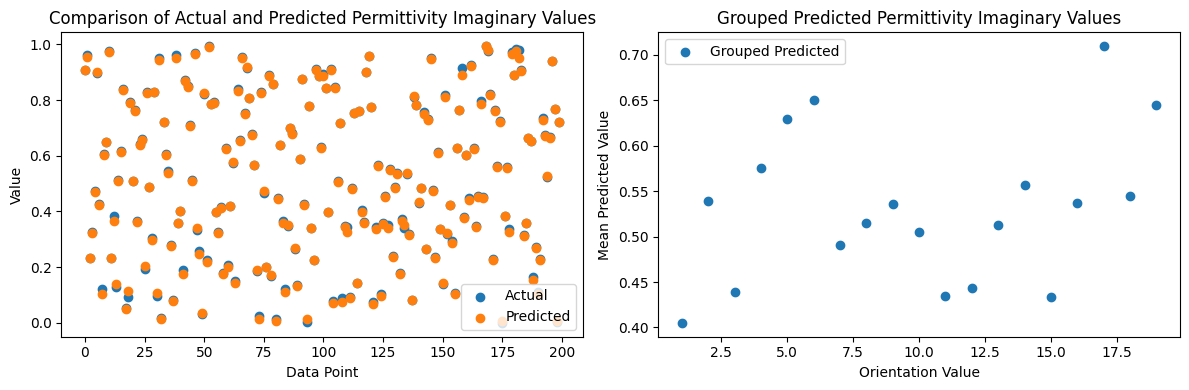

In [138]:
df_predicted = pd.DataFrame({'orientation_value': collapse_orientation_int['orientation'][split_point:], 'y_pred': y_pred[:, 1]})

# Group the predicted values by "orientation_value" and calculate the mean
y_pred_grouped = df_predicted.groupby('orientation_value')['y_pred'].mean().reset_index()

# Plot the comparison of actual and predicted permittivity real values for all data points
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_val)), y_val[:, 1], label='Actual')
plt.scatter(range(len(y_pred)), y_pred[:, 1], label='Predicted')
plt.title('Comparison of Actual and Predicted Permittivity Imaginary Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

# Plot the grouped predicted permittivity real values for each orientation category
plt.subplot(1, 2, 2)
plt.scatter(y_pred_grouped['orientation_value'], y_pred_grouped['y_pred'], label='Grouped Predicted')
plt.title('Grouped Predicted Permittivity Imaginary Values')
plt.xlabel('Orientation Value')
plt.ylabel('Mean Predicted Value')
plt.legend()

plt.tight_layout()
plt.show()